As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 

The aim is to analyse the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyse the impact on player retention and game rounds.

In [1]:
import os

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.stats.api as sms

import warnings

# import custom module
import sys
sys.path.append('../Modules')
import statistical_tests as st

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

Data Description:

* userid: A unique number that identifies each player.
* version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40)
* sum_gamerounds: The number of game rounds played by the player during the first 14 days after install.
* retention_1: Did the player come back and play 1 day after installing?
* retention_7: Did the player come back and play 7 days after installing?

In [2]:
df = pd.read_csv("../Data/cookie_cats.csv")
display(df.head())
display(df.describe())
print(df.shape)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


(90189, 5)


In [3]:
df["retention"] = np.where((df["retention_1"]==True) & (df["retention_7"]==True), 1, 0)
df["version"] = np.where(df["version"]=="gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention
0,116,A,3,False,False,0
1,337,A,38,True,False,0
2,377,B,165,True,False,0
3,483,B,1,False,False,0
4,488,B,179,True,True,1


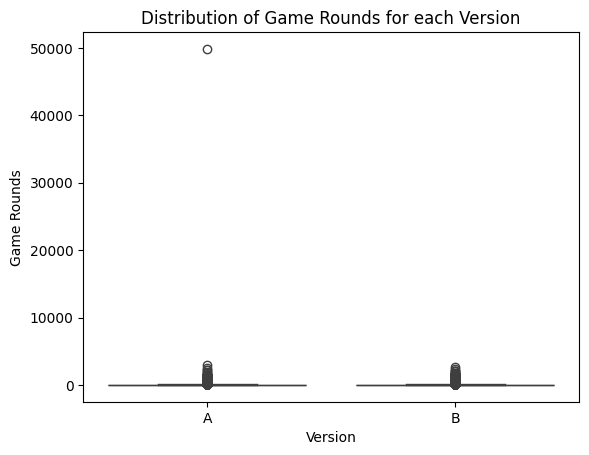

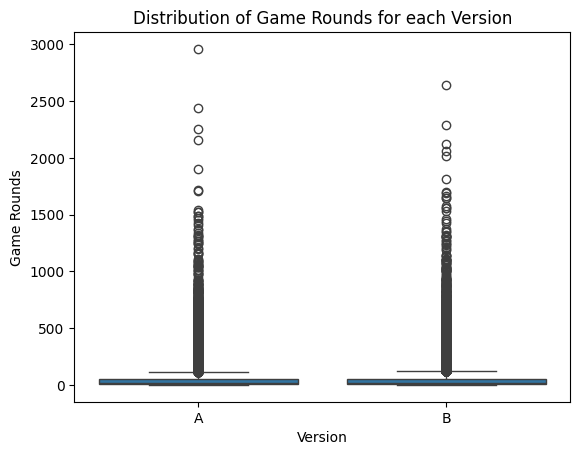

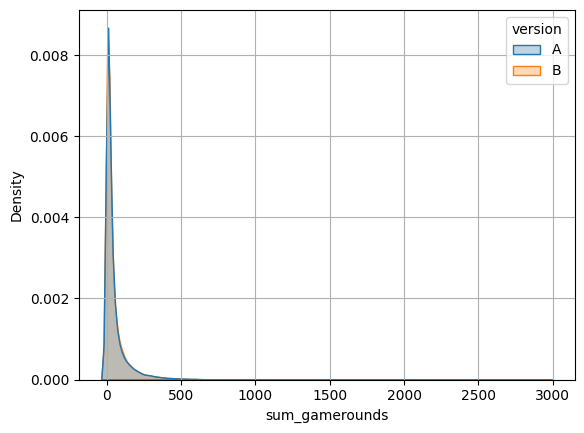

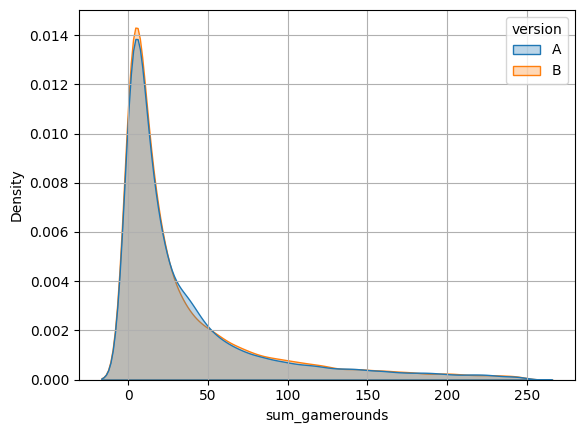

In [4]:
def create_dist_plots():
    sns.boxplot(data=df, x="version", y="sum_gamerounds")
    plt.title("Distribution of Game Rounds for each Version")
    plt.xlabel("Version")
    plt.ylabel("Game Rounds")
    plt.show()
    
create_dist_plots() # one major outlier
df = df[df["sum_gamerounds"] < 30000]
create_dist_plots()
sns.kdeplot(data=df, x="sum_gamerounds", hue="version", fill=True, alpha=0.3)
plt.grid()
plt.show()
sns.kdeplot(data=df[df["sum_gamerounds"] < 250], x="sum_gamerounds", hue="version", fill=True, alpha=0.3)
plt.grid()
plt.show()

In [5]:
help(st.AB_Test)

Help on function AB_Test in module statistical_tests:

AB_Test(df, group, target)
    Perform an A/B test given the following:
    1. dataframe
    2. group: a column in the dataframe containing the A/B groups
    3. target: a column in the dataframe containing the value



In [6]:
st.AB_Test(df, group="version", target="sum_gamerounds")

A/B Test Hypothesis
H0: A == B
H1: A != B


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar


* __Test Type = Non-Parametric__: indicates that the data did not meet the assumptions required for parametric tests (i.e., normality of the data distribution).
* __AB Hypothesis = Fail to Reject H0__: suggests that the test did not find enough statistical evidence to reject the null hypothesis (no difference between A and B).
* __p-value = 0.050892__: the p-value is slightly above the typical significance threshold (0.05), which aligns with the decision to "Fail to Reject H0." This means that the difference observed between groups A and B is not statistically significant at the 5% level.
* __Comment = A/B groups are similar__: indicates that based on the test results, the A and B groups do not have statistically significant differences in their performance concerning the target metric being analysed.

The A/B test did not provide enough evidence to conclude that A and B differ significantly in terms of retention. The data suggests that any observed differences could be due to random variation rather than a true effect of the changed gates.

In [7]:
# Calculate the required sample size

cross_tab = pd.crosstab(df['version'], df['retention_7'], normalize='index')
p1 = cross_tab.iloc[0, 1] 
p2 = p1 + 0.05

print("P1 =", p1)
print("P2 =", p2)

sample_size = sms.NormalIndPower().solve_power(
    sms.proportion_effectsize(p1, p2), 
    power=0.8, 
    alpha=0.05, 
    ratio=1
)
print(f"Required sample size for each group: {sample_size:.0f}")

P1 = 0.19018322557551623
P2 = 0.24018322557551625
Required sample size for each group: 1057


In [8]:
# Collect random sample

def choose_random_sample(df, random_state=42):
    return df.sample(n=int(sample_size), random_state=random_state)

df_sample = df.groupby('version', group_keys=False).apply(choose_random_sample)
df_sample

,userid,version,sum_gamerounds,retention_1,retention_7,retention
58981,6531088,A,55,True,False,0
72248,8003089,A,2,False,False,0
50215,5566807,A,23,True,False,0
609,64235,A,1,False,False,0
56038,6210551,A,7,False,False,0
...,...,...,...,...,...,...
61283,6791628,B,1,False,False,0
7382,815086,B,36,True,False,0
24441,2718564,B,30,True,False,0
26328,2932552,B,10,False,False,0


In [9]:
# Create the contingency table
contingency_table = pd.crosstab(df_sample['version'], df_sample['retention_1'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("*"*80)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("*"*80) 

# Count the number of successes (converted) and trials in each group
success_A = contingency_table.iloc[1,1]
trials_A = contingency_table.iloc[1,0] + contingency_table.iloc[1,1]
success_B = contingency_table.iloc[0,1]
trials_B = contingency_table.iloc[0,0] + contingency_table.iloc[0,1]

# Perform the z-test for proportions
z_stat, p_value = sm.stats.proportions_ztest(
    [success_A, success_B], 
    [trials_A, trials_B], 
    alternative='smaller'
)

# Print the results
print(f"\nZ-statistic:\t{z_stat:.4f}")
print(f"P-value:\t{p_value:.4f}\n")
print("*"*80) 

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("\nReject the null hypothesis.\nThere is a significant difference in proportions.")
else:
    print("\nFail to reject the null hypothesis.\nProportions are not significantly different.")

Contingency Table with Frequencies:


retention_1,False,True
version,,
A,603,454
B,576,481


********************************************************************************

Row Percentages:


retention_1,False,True
version,,
A,57.048250,42.951750
B,54.493851,45.506149


********************************************************************************

Z-statistic:	1.1824
P-value:	0.8815

********************************************************************************

Fail to reject the null hypothesis.
Proportions are not significantly different.


In [10]:
# Create the contingency table
contingency_table = pd.crosstab(df_sample['version'], df_sample['retention_7'])

print("Contingency Table with Frequencies:")
display(contingency_table)
print("*"*80)

# Calculate row percentages
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nRow Percentages:")
display(row_percentages)
print("*"*80) 

# Count the number of successes (converted) and trials in each group
success_A = contingency_table.iloc[1,1]
trials_A = contingency_table.iloc[1,0] + contingency_table.iloc[1,1]
success_B = contingency_table.iloc[0,1]
trials_B = contingency_table.iloc[0,0] + contingency_table.iloc[0,1]

# Perform the z-test for proportions
z_stat, p_value = sm.stats.proportions_ztest(
    [success_A, success_B], 
    [trials_A, trials_B], 
    alternative='smaller'
)

# Print the results
print(f"\nZ-statistic: {z_stat: .4f}")
print(f"P-value: {p_value: .4f}\n")
print("*"*80) 

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("\nReject the null hypothesis.\nThere is a significant difference in proportions.")
else:
    print("\nFail to reject the null hypothesis.\nProportions are not significantly different.")

Contingency Table with Frequencies:


retention_7,False,True
version,,
A,851,206
B,855,202


********************************************************************************

Row Percentages:


retention_7,False,True
version,,
A,80.510880,19.489120
B,80.889309,19.110691


********************************************************************************

Z-statistic: -0.2204
P-value:  0.4128

********************************************************************************

Fail to reject the null hypothesis.
Proportions are not significantly different.
